# Lattice SVM

A support vector machine (SVM) is a classifier that attempts to find a maximum margin linear separator for different classes in a very high dimensional implicit feature space. The feature space is usually not explicitly calculated but is instead accessed via a kernel function which provides the effective dot product in the feature space, this has the advantage that we can deal with very large implicit feature spaces this way. In fact the dimensionality of the implicit feature space of most commonly used SVM variants is usually quoted as being infinite, for example the Gaussian kernel is one example. But the high effective feature dimensionality still comes with a high computational cost, we must somehow deal with an N by N matrix of similarities relating all of our training points to each other (the matrix of kernelized "feature dot products").

<!-- TEASER_END -->

This matrix of dot products then gives us all the information which we can have about the relative positions of our data points in this high dimensional feature space. This matrix is called the similarity matrix and in practice instead of beginning with a desired feature space we begin with a specification of a similarity function (the kernel) and hope that the associated feature space works well for our particular problem. The support vector part of support vector machine refers to the idea that we choose just a subset of our training examples (support vectors) which specify a hyperplane which seperates (or nearly separates) our classes.

This approach however requires that we know the similarity between every pair of training samples in our dataset. Because of implementations of SVM algorithms don't tend to scale very well to large datasets. One truly beautiful approach to this problem is to draw features $z_i(x)$ from a function space such that the expectation of the dot product of an ensemble of those features $Z(x) = [z_0(x), z_1(x), ...]$ is equal to our kernel $E[Z(x_i)^TZ(x_j)] = K(x_i, x_j)$.

To see a more detailed treatment and how to choose appropriate distributions of random features $z_i$ see the paper "Random Features For Large Scale Kernel Machines" by Ali Rahimi and Benjamin Recht. http://machinelearning.wustl.edu/mlpapers/paper_files/NIPS2007_833.pdf 

This sort of approach is extremely attractive since we have the freedom to pick any number of random features that we like and our fitting algorithm becomes the solution to a linear support vector machine whose solution we can much more rapidly evaluate.

Picking random features has a certain kind of attractiveness but why not try to deterministically pick features which will give us a good approximation to a particular exact SVM specification? Surely a clever deterministic choice of $z_i$ based somehow on our data could outperform randomly chosen ones.
Lets attempt to do this for the Gaussian kernel.
We may define an isotropic Gaussian kernel with a scale parameter $\sigma$ as follows

$$K(x, y) = exp ( \frac{-1}{\sigma^2} (x-y)^T(x-y))$$

where $x$ and $y$ are D dimensional vectors. It is immediately clear that we can factor the kernel into a product of a gaussian of each of $x_1$ and $x_2$ multiplied by an exponential of their product.

$$K(x_1, x_2) = exp(\frac{-1}{\sigma^2} x^2)~exp(\frac{-1}{\sigma^2} y^2)~exp(\frac{2}{\sigma^2} xy)$$

We can then utilize the tailor series expansion of the exponential to get an explicit representation of a feature space transform $\Phi(x)$ which would give rist to the gaussian kernel

$$
\Phi(x) = exp(\frac{-1}{\sigma^2} x^2)~[1, \sqrt{\frac{2}{1!}}~\frac{x}{\sigma}, \sqrt{\frac{2}{2!}}~(\frac{x}{\sigma})^2, ...]^T
$$

Clearly $\Phi(x)^T\Phi(y) = K(x, y)$ since the gaussian out front of the vector gives us the two gaussians in our product above and the matrix product is the equivalent of the tailor series expansion of the exponential of xy (since each side contributes the square route of the taylor coefficients).

We could of course simply use this expansion as our chosen set of approximating features $z_i(x)$ but this does not seem like a very good choice. For one thing we haven't even taken into account the actual distribution of our data in any way! Also we know that taylor expansions are only really useful in the regime where x is small and so this would likely turn out to be a good set of features only very near to the origin. 

We can solve the problem of the expansion being poor for any particular point in our original feature space by centering the expansion around that point.  But why choose just one? We could center such an expansion on each and every one of our data points in our sample! While no doubt this would give us a good approximation to the exact SVM since we would be explicitly calculating even more features than there are points we would have dramatically increased the computational complexity of the problem as well as only achieving an approximation instead of an exact solution.

What we require is some method of picking sets of points which would be appropriate to expand around. We could attempt to use the centroids of a k-means algorithm but the expansion around each point will only be effective in a radius roughly $\sigma$ and the points k-means chooses are unlikely to come back nicely regularly spaced $\sigma$ apart.

This is where we invoke the power of lattices. Informally a lattice is a regular array of points. For any finite set of points $p_i$ the integer linear combinations of those points $p=n_0*p_0 + n_1*p_1 + ...$ form a point lattice. The regular rectangular grid where the points $p_i$ are all orthogonal to each other is a lattice and is usually denoted $Z_n$. There are lots of other interesting and useful sorts of point lattices. Lattices are often used in codes as vector quantizers which is what we will use them for here.

If we pick a lattice in which the points are spaced roughly $\sigma$ apart and then quantize our data onto it most data points which have a spacing less than $\sigma$ will need only one family of terms in the expansion. This can give us an extremely hefty discount in model complexity since we can choose our lattice in such a way that thousands of data points get quantized to the same centroid and get only one set of features and rare data points which get quantized onto a unique point get full weight.

# Numerical Experiments

We shall apply this idea to the downsampled mnist digits included in sklearn. We have picked this smaller dataset so tha the examples compute quickly and in order to efficiently apply the matching algorithms below we need there to be only a relatively small number of dimensions so we would not gain much from using the full $28^2$ features in the original MNIST digit set.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
import sklearn.decomposition
from sklearn.datasets import load_digits

import scipy
import scipy.sparse
import scipy.sparse.linalg
import numpy as np

import latbin

In [2]:
plt.rcParams.update(
    {
        "figure.figsize":(12, 5),
        "font.size":16,
        "image.interpolation":"nearest",
        "image.cmap":"afmhot",
    }
)

In [3]:
digit_ds = load_digits(n_class=10)

images = digit_ds["images"].reshape((-1, 8*8))
labels = digit_ds["target"]


# A First Pass

As a first attempt we will use just a first order expansion and we will use latbin.matching.match to help us build sparse matrices for the centroid expanded features.

## Reducing the dimension

Unfortunately the lattice matching algorithms in latbin are not optimized for very high numbers of dimensions. The number of edge cases blows up exponentially and I haven't yet figured out how to deal with that. You get almost all the matches if you use the $A_D$ lattice and the innermost shell of lattice points in which case you get D(D+1) proportional run times which is steep but manageable. However at the moment i have no option to do an approximate search and this makes the matching run time exponential in the number of dimensions.

That means that we need to do some dimensionality reduction before we can apply lattice SVM. Past experience shows that applying dimensionality reduction often actually improves the quality of the similarity anyway so we are on good ground here. We will use PCA as an initial dimension reduction scheme since it is label agnostic and our data has no outliers.

We can start with two dimensions so that we can fully visualize the input space and the decision function.

In [68]:
ndim = 2
pca = sklearn.decomposition.PCA(n_components=ndim).fit(images)

n_train = 1000
train = pca.transform(images[:n_train])
train_labels = labels[:n_train]

test = pca.transform(images[n_train:])
test_labels = labels[n_train:]

# Picking the Kernel Scale

We want to pick a kernel size that is smaller than the average distance between images within the same label class (intra-digital distance) so that our model has a chance to capture some of the morphology of the individual digits. However we don't want to pick a kernel scale that is so small that a random image might end up having no neighbors that close.

In [69]:
n_samples_targ = 1000

inter_digit_pairs, inter_digit_dists= latbin.scaling.sampled_pair_distances(train, n_samples=1500)
#enforce looking at distances only for pairs of images with different associated digits
mask = train_labels[inter_digit_pairs[:, 0]] != train_labels[inter_digit_pairs[:, 1]]

inter_digit_dists = inter_digit_dists[mask]

In [70]:
intra_digit_dists = []

for i in range(10):
    spairs, cdists = latbin.scaling.sampled_pair_distances(
        train[train_labels==i], 
        n_samples=n_samples_targ
    )
    intra_digit_dists.append(cdists)

In [71]:
hist_kwargs = {
    "bins":25,
    "histtype":"step",
    "lw":3,
    "normed":True,
    "alpha":0.6,
    "cumulative":True,
    "range":(0, 70)
}

hres = plt.hist(inter_digit_dists, label = "inter digit", color="k", **hist_kwargs)

plt.hist(intra_digit_dists[i], label="intra digit", color="r", **hist_kwargs)
for i in range(1, 10):
    plt.hist(intra_digit_dists[i], color="r", **hist_kwargs)

kernel_scale = 7.0
plt.axvline(kernel_scale, lw=3, label="kernel_scale")

plt.ylim(0, 1.1)
plt.xlabel("Image Distance")
plt.ylabel("Cumulative Probability")
plt.legend(loc=4)

In [108]:
class LatticeSVC(object):
    
    def __init__(
        self,
        lattice_factory,
        scale,
        min_pts_expand,
        rbf,
        max_match_dist,
    ):
        self.lattice_factory = lattice_factory
        self.scale = scale
        self.min_pts_expand = min_pts_expand
        self.rbf = rbf
        self.max_match_dist = max_match_dist
    
    def feature_matrix(self, x, centroids=None):
        if centroids is None:
            centroids = self.centroids
        
        npts = len(x)
        ncents = len(centroids)
        
        ix1, ix2, dists = latbin.matching.match(
            x, 
            centroids, 
            tolerance=self.max_match_dist
        )
        
        delta_vectors = (train[ix1]-centroids[ix2])/self.scale
        rbf_sim = self.rbf(dists/self.scale)
        
        zero_order_features = scipy.sparse.coo_matrix(
            (
                rbf_sim,
                [ix1, ix2],
            ),
            shape=(npts, ncents),
        )
        
        first_order_features = []
        for dim_idx in range(ndim):
            cmat = scipy.sparse.coo_matrix(
                (
                    rbf_sim*delta_vectors[:, dim_idx],
                    [ix1, ix2],
                ),
                shape=(npts, ncents),
            )
            first_order_features.append(cmat)
        
        features = []
        features.append(zero_order_features)
        features.extend(first_order_features)
        feature_matrix = scipy.sparse.hstack(features)
        
        return feature_matrix
    
    def fit(self, x, y):
        lat = self.lattice_factory(ndim, scale=self.scale)
        self.lat = lat
        
        #bin the data onto the lattice
        gb = self.lat.bin(x)
        
        #count the number of points in each bin
        svec = gb.size().values
        
        #find the mean of the bins and mask out the bins with too few values
        centroids = gb.mean()[svec >= self.min_pts_expand].values
        self.centroids = centroids
        
        features = self.feature_matrix(x, centroids=centroids)     
        
        self.svc = sklearn.svm.LinearSVC()
        self.svc.fit(features, y)
    
    def predict(self, x):
        features = self.feature_matrix(x)
        return self.svc.predict(features)
    
    def decision_function(self, x):
        features = self.feature_matrix(x)
        return features*self.svc.coef_.transpose()


In [109]:
lsvc = LatticeSVC(
    lattice_factory=latbin.DLattice, 
    scale=kernel_scale, 
    min_pts_expand=1,
    rbf = lambda x: np.exp(-x**2),
    max_match_dist=25,
)
lsvc.fit(train, train_labels)

In [110]:
train_pred = lsvc.predict(train)
test_pred = lsvc.predict(test)


In [111]:
def accuracy(pred, true, thresh=0.5):
    return np.sum(np.abs(pred-true) < thresh)/len(true)

In [112]:
train_lat_accuracy = accuracy(train_pred, train_labels)
test_lat_accuracy = accuracy(test_pred, test_labels)

print("train accuracy {:4.4f}".format(train_lat_accuracy))
print("test  accuracy {:4.4f}".format(test_lat_accuracy))

train accuracy 0.7050
test  accuracy 0.3839


In [113]:
lsvc.centroids.shape

(35, 2)

In [114]:
lsvc.svc.coef_.shape

(10, 105)

# Comparison with Scikit-Learn's rbf SVC Implementation

So we get the right digit 38% of the time on the test set is that good? I was hoping to be able to do a direct comparison between the results of this classifier and the sklearn.svm.SVC classifier with the same kernel. I think that the kernel="rbf" option in sklearn is a gaussian kernel though I am uncertain of whether gamma would correspond to $1/sigma$ or $1/sigma^2$ in the implementation here. 

Even if I could resolve that ambiguity however a direct comparison does not seem easily achievable. The SVC object is using a one versus one "ovo" multi-class classification scheme and the LinearSVC implementation only has an option to do one versus rest "ovr".

https://en.wikipedia.org/wiki/Multiclass_classification


In [116]:
svc = sklearn.svm.SVC(gamma=1.0/kernel_scale)
svc.fit(train, train_labels)

train_pred_sklearn = svc.predict(train)
test_pred_sklearn = svc.predict(test)

train_sklearn_accuracy = accuracy(train_pred_sklearn, train_labels)
test_sklearn_accuracy = accuracy(test_pred_sklearn, test_labels)

print("train accuracy {:4.4f}".format(train_sklearn_accuracy))
print("test  accuracy {:4.4f}".format(test_sklearn_accuracy))

train accuracy 0.7490
test  accuracy 0.6136


So the default svc classifier does a better job of classifying the samples than our naive implementation. But we note that the lattice SVM is fitting just 10 seperating hyper planes for ovr each with just 105 coefficients. By contrast the SVC fits 10*9/2 = 45 different hyper planes and determines a hyperplane as a linear combination of each of its 1000 input training samples. That is effectively 45,000 free parameters versus only 10,500. Saving on model complexity was our goal but in order to do a really fair comparison we need to use a one-versus-rest classifier for the exact SVC.

Though there is an option to specify decision_function_shape="ovr" in the SVC object constructor this doesn't change the number and type of classifiers trained but simply collapses their votes into a "ovr" shaped resulting matrix. This means we have to build a wrapper ourselves if we want to do a proper comparision.

In [156]:
class OVRSVC(object):
    
    def __init__(self, *args, **kwargs):
        self.args = args
        self.kwargs = kwargs
    
    def fit(self, x, y):
        svcs = []
        for label in np.unique(y):
            svcs.append(sklearn.svm.SVC(*self.args, **self.kwargs).fit(x, y==label))
        self.svcs = svcs
    
    def decision_function(self, x):
        decf = np.zeros((len(x), len(self.svcs)))
        for i in range(len(self.svcs)):
            csvc = self.svcs[i]
            margin = csvc.decision_function(x)
            decf[:, i] = margin
        return decf
    
    def predict(self, x):
        return np.argmax(self.decision_function(x), axis=1)

In [157]:
ovrsvc = OVRSVC(C=2.0, gamma=1.0/kernel_scale)
ovrsvc.fit(train, train_labels)

train_pred_skovr = ovrsvc.predict(train)
test_pred_skovr = ovrsvc.predict(test)

train_skovr_accuracy = accuracy(train_pred_skovr, train_labels)
test_skovr_accuracy = accuracy(test_pred_skovr, test_labels)

print("train accuracy {:4.4f}".format(train_skovr_accuracy))
print("test  accuracy {:4.4f}".format(test_skovr_accuracy))

train accuracy 0.7890
test  accuracy 0.6085


Even doing ovr the regular SVC implementation outperforms the Lattice implementation. In fact the training set accuracy actually went up a bit which is interesting considering that there are nearly 5 times fewer coefficients involved in the model specification. 

# Decision Function Comparison

Now that we are training the same hyper planes in principle we can take a look at their decision functions and see how well they seperate out each class and what they look like in the input space.

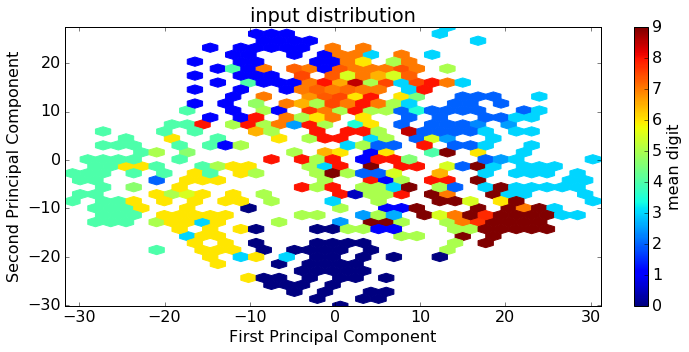

In [159]:
plt.hexbin(test[:, 0], test[:, 1], C=test_labels, gridsize=35, cmap="jet")
plt.title("input distribution")
cbar = plt.colorbar()
cbar.set_label("mean digit")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")

In [160]:
decf_lsvc = lsvc.decision_function(test)
decf_svc = ovrsvc.decision_function(test)


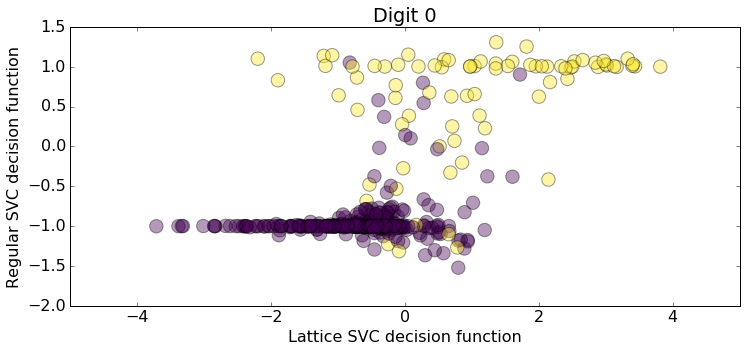

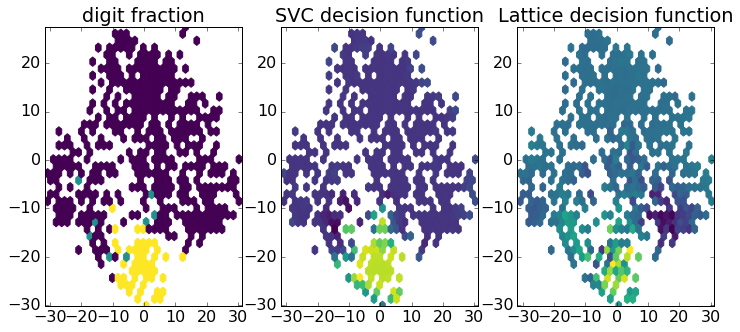

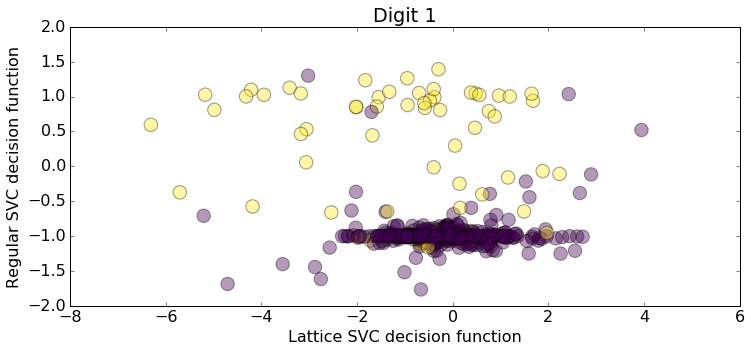

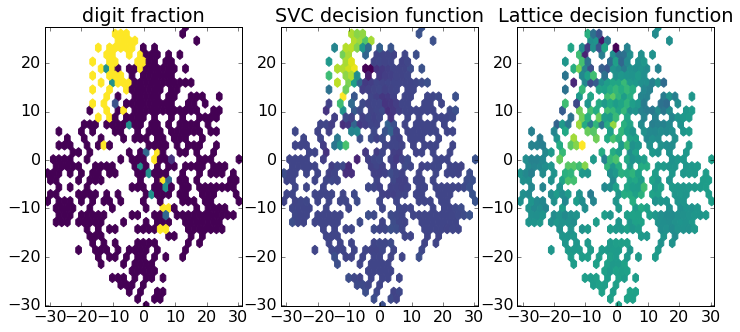

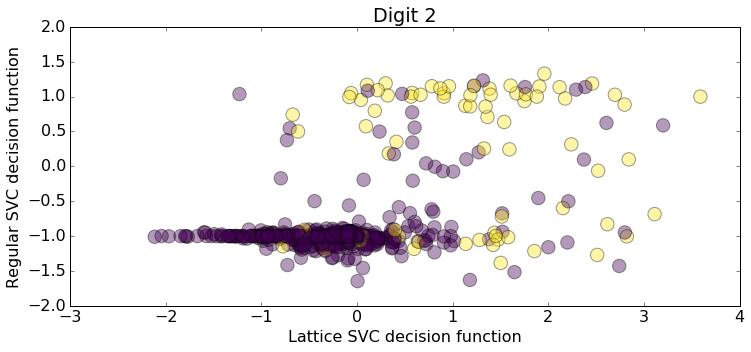

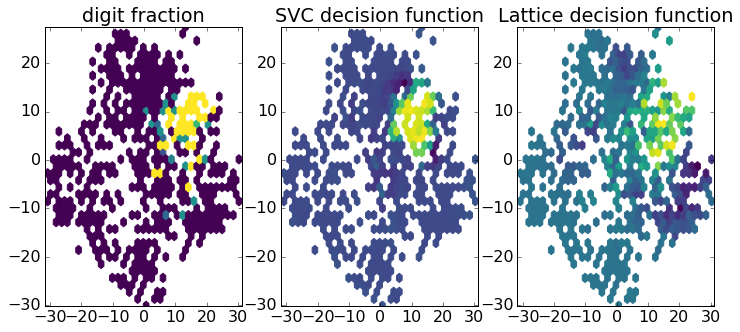

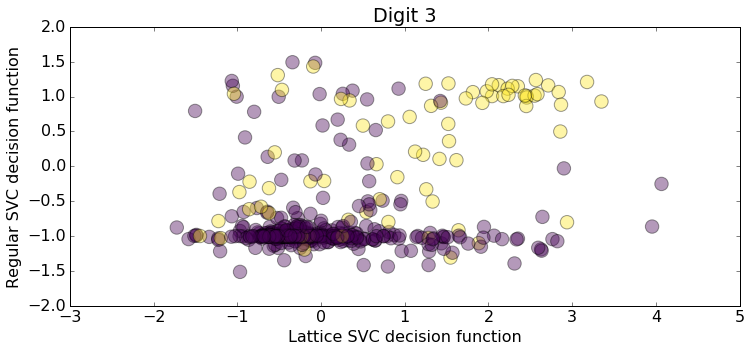

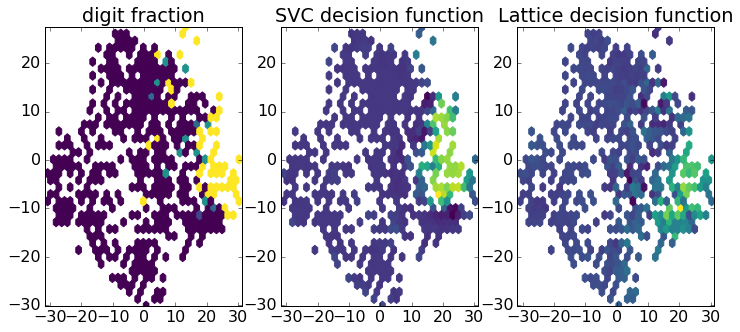

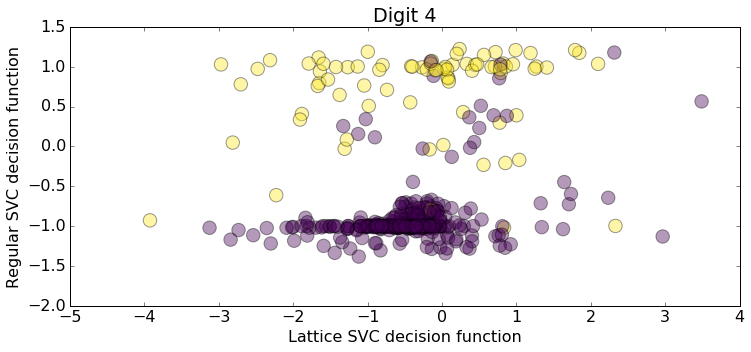

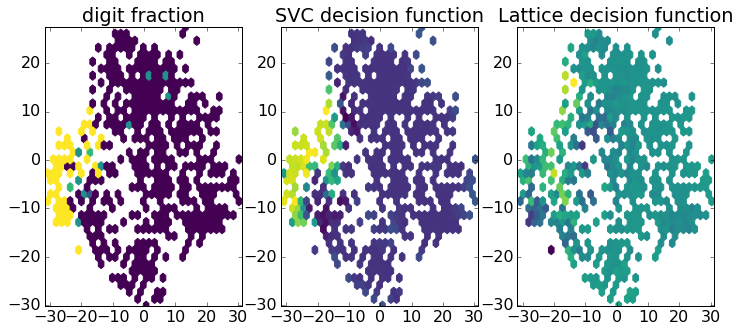

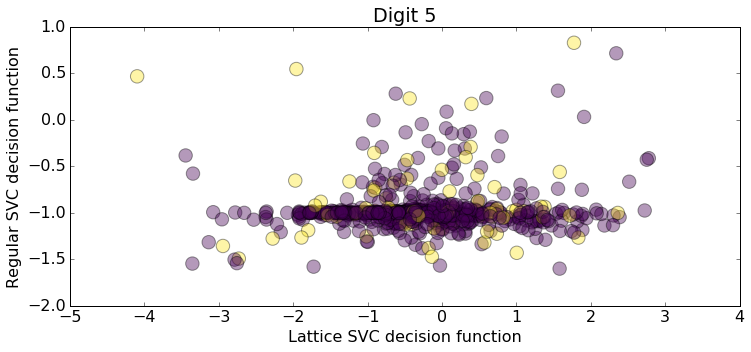

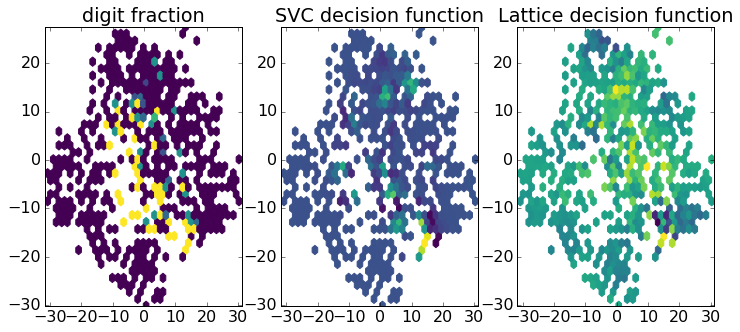

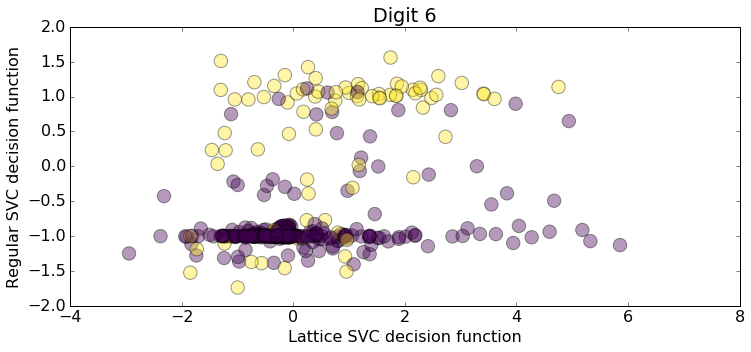

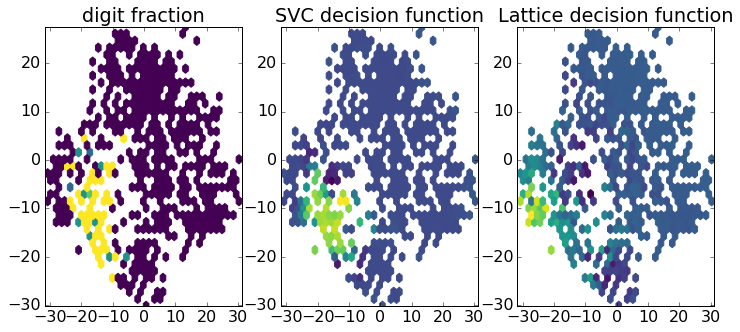

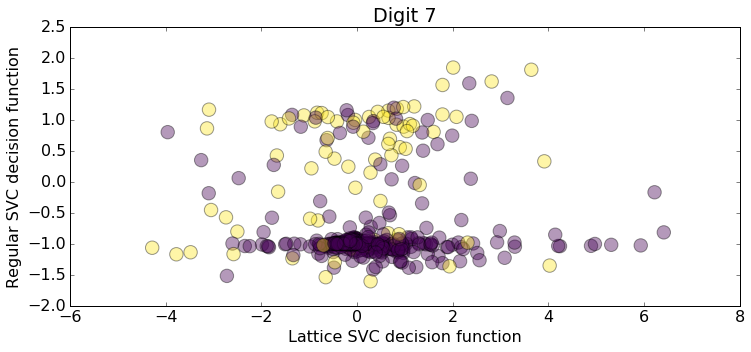

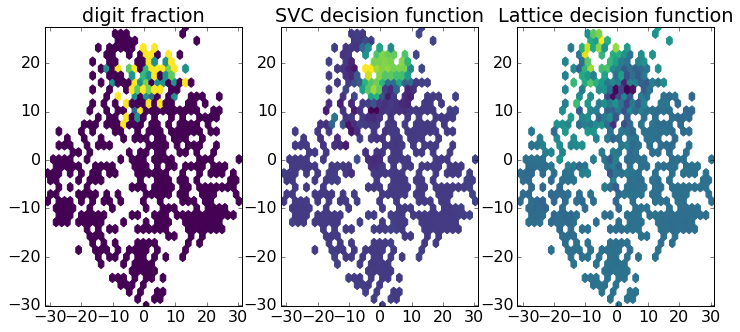

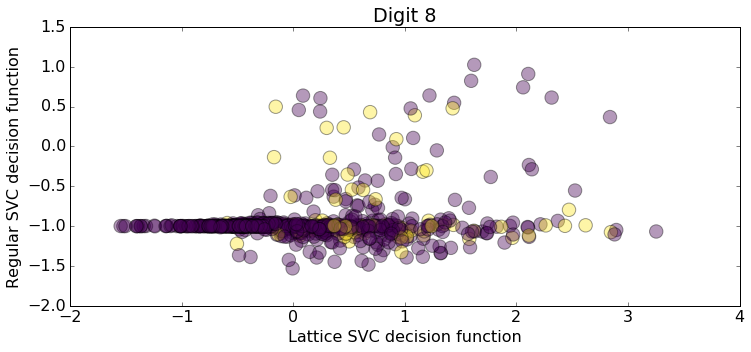

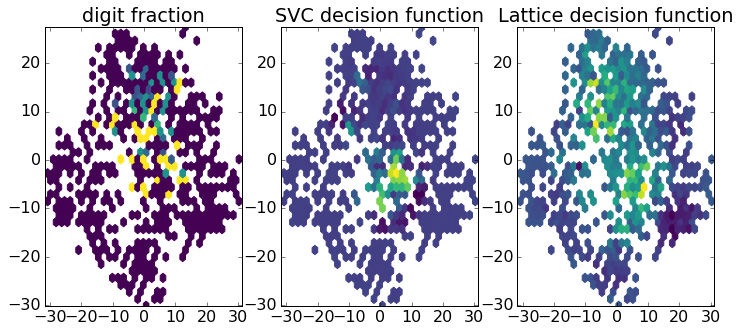

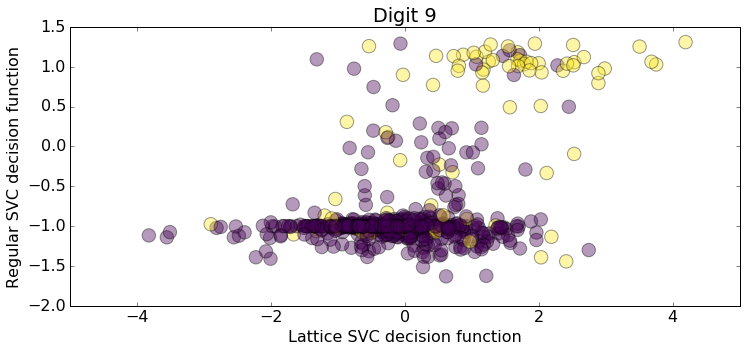

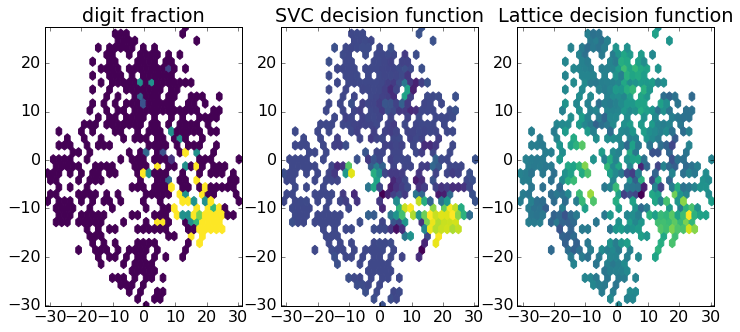

In [163]:
hex_kwargs = {"gridsize":35, "cmap":"viridis"}

for i in range(10):
    plt.scatter(
        decf_lsvc[:, i], 
        decf_svc[:, i], 
        s=180, 
        c=test_labels==i, 
        alpha=0.4, 
        cmap="viridis"
    )
    plt.xlabel("Lattice SVC decision function")
    plt.ylabel("Regular SVC decision function")
    plt.title("Digit {}".format(i))
    plt.show()
    
    fig, axes = plt.subplots(1, 3)
    axes[0].hexbin(test[:, 0], test[:, 1], C=test_labels==i, vmin=0, vmax=1.0, **hex_kwargs)
    axes[1].hexbin(test[:, 0], test[:, 1], C=decf_svc[:, i], **hex_kwargs)
    axes[2].hexbin(test[:, 0], test[:, 1], C=decf_lsvc[:, i], **hex_kwargs)
    
    axes[0].set_title("digit fraction")
    axes[1].set_title("SVC decision function")
    axes[2].set_title("Lattice decision function")
    plt.show()

    

For some reason the regular SVC decision function values tend to be close to either -1.0 or +1.0 although they are clearly not constrained to lie between them. Although it is clear that the decision functions do have some sort of relationship to each other their distributions are starkly different. It seems as though the SVC decision function is being passed through a logistic function.
